# Electromiografía: Detección de eventos en grabaciones EMG
### Flores Oliva Alejandro Elliot
#### Licenciatura en Física Biomédica en Ciencias Biológicas , Facultad de Ciencias, Universidad Nacional Autónoma de México.

##### Análisis elaborado por: Noel Isaías Plascencia Díaz<sup>1</sup>, Mitsui Myrna Salgado Saito<sup>2</sup>, & Erin C. McKiernan<sup>3</sup>

<sup>1</sup> Licenciatura en Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>2</sup> Licenciatura en Ciencias de la Tierra, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>3</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>

## Índice:
[1. Resumen](#Resumen)

[2. Configuración/Diseño del notebook. ](#Configuración/Diseñodelnotebook)

[3. Detección de eventos.](#Deteccióndeeventos)

[4. Cargar y preprocesar los datos.](#Cargarypreprocesarlosdatos)

[5. Configuración del detector de eventos.](#Configuracióndeldetectordeeventos)

[6. Contando el número de detecciones de picos por bin.](#Contandoelnúmerodedeteccionesdepicosporbin)


<a id='Resumen'></a>
## Resumen

Este notebook abordará un análisis para la detección de eventos en grabaciones de electromiografía, esto puede ayudarnos a identificar los pulsos en la EMG que están potencialmente relacionados con la contribución acumulada de potenciales de acción individuales, también cuantificara el número de detecciones de picos por bin.

<a id='Configuración/Diseñodelnotebook'></a>
## Configuración/Diseño del notebook

#### Comandos para configuración de las imágenes/gráficos 

In [1]:
# Comando para ver figuras en el cuaderno Jupyter.
%matplotlib inline 

# Módulo de trazado.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker                            #Unidades de cambio de escala.
from mpl_toolkits.axes_grid1.inset_locator import mark_inset  #Recuadros de figuras.
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  #Recuadros de figuras.

# Comandos para crear figuras de alta resolución con etiquetas grandes.
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18                #Tamaño de fuente para etiquetas de figuras.
plt.rcParams['axes.titlesize'] = 20                #Tamaño de fuente para títulos de figuras.
plt.rcParams['font.size'] = 16                     #Tamaño de fuente para números de figura.
plt.rcParams['lines.linewidth'] = 1.6              #Ancho de línea para trazar

##### Importación de librerías.

In [3]:
import csv                      #Permite la importación y exportación de hojas de cálculo y bases de datos.
import math                     #Permite usar funciones matemáticas definidas en el estándar de C.
import matplotlib.pyplot as plt #Módulo de trazado.
import pandas as pd             #Sirve para el manejo y análisis de estructuras de datos.
import scipy as sc              #Funciones importadas de numpy.
from scipy import signal        #Herramientas de procesamiento de señales, funciones de filtrado, algoritmos de interpolación.
from scipy.fftpack import fft   #Devuelve la transformada discreta de Fourier de secuencia real o compleja.
from scipy.signal import butter, lfilter, filtfilt
from scipy.integrate import trapz, cumtrapz #Integral acumulativa y(x) usando la regla trapezoidal compuesta.

import numpy as np              #Creación de vectores y matrices multidimensionales,permite usar otras funciones matemáticas.
import wave                     #El módulo proporciona una interfaz para el formato de sonido WAV.
import sys                      #Permite el acceso a funciones y objetos mantenidos por del intérprete.

#Este módulo contiene clases para configurar la localización y el formato de las garrapatas (“ticks”), proporcionan localizadores y formateadores de ticks.
from matplotlib.ticker import MaxNLocator #Encuentra hasta un número máximo de intervalos con ticks en lugares adecuados.
sys.path.insert(1, r'./../functions')  #Agregar a pythonpath(ubicación del módulo).

<a id='Deteccióndeeventos'></a>
## Detección de eventos

Para la localización de eventos se usará un método de detección que permitirá identificar los pulsos en la EMG que están potencialmente relacionados con la contribución acumulada de potenciales de acción individuales.

In [4]:
def shorten_signal(signal, threshold):
    dif_signal = np.diff(signal)
    startind=np.where(dif_signal>threshold)[0][0]
    
    endind=np.where(dif_signal[::-1]>threshold)[0][0]
    endind=len(dif_signal)-endind
    return(signal[startind:endind])

##### Extraer y graficar los datos

Las grabaciones de EMG se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio en formato .wav. Utilizando las librerías para visualizar nuestros datos, posteriormente con el uso de otros comandos almacenaremos los resultados relevantes para los cálculos/ análisis posteriores.

In [32]:
def EMG(archivo,graph):
    
    # Visualización del archivo .wav, es necesario saber la ubicación del archivo y su nombre.
    #Los archivos WAV contienen una secuencia de bits que representan los datos de audio sin procesar.
    record = wave.open(archivo)
    
    #Obtención del número de canales, frecuencia de muestreo, número de fotogramas. 
    NumCanales = record.getnchannels()      #Número de canales y retorna el número de canales de audio. 
    N= record.getnframes()                  #Número de fotogramas.
    FrecMuestreo = record.getframerate()    #Retorna la frecuencia del muestreo.
    AnchoMuestra=record.getsampwidth()      #Retorna el ancho de la muestra en bytes.
    
    #Análisis de datos del archivo .wav
    dstr = record.readframes(N * NumCanales) #Lee y retorna como máximo n cuadros de audio, como un objeto bytes.
    waveData = np.frombuffer(dstr, np.int16) #np.frombuffer es una función para crear una matriz unidimensional utilizando un búfer. 
    #El módulo de ondas "wave" proporciona una interfaz conveniente para el formato de sonido WAV. 
    
    #Imprimimos el número de canales, la frecuencia de muestreo y el ancho de muestra.
   # print('La grabación tiene %d canal(ó canales).' % (NumCanales))
   # print('La frecuencia de muestreo de la grabación es %d Hz.' % (FrecMuestreo))
   # print('La grabación tiene un ancho de muestra de %d' % (AnchoMuestra))
    
    #Calcular la ventana, se utiliza la función linspace para crear matrices con valores espaciados uniformemente, esta 
    #función utiliza una matriz con 5 valores que se encuentren entre 0 y 2.
    EMGtiempo=np.linspace(0, len(waveData)/FrecMuestreo, num=len(waveData))
    
    #Calcular la frecuencia.
    frec = 1/np.mean(np.diff(EMGtiempo))
    
    #Filtro Butterworth de paso de banda a 10-400Hz.
    b, a = butter(2, ([10, 400]/(frec/2)), btype = 'bandpass')
    dataf = filtfilt(b, a, waveData)
    
    
    #Rectificar la señal EMG filtrada.
    AbsSeñal = np.absolute(dataf)
    Abstiempo=np.linspace(0, len(AbsSeñal)/FrecMuestreo, num=len(AbsSeñal))
    
    
    #Filtro Butterworth de paso bajo para detección de envolvente.
    lowp = 8
    sfrec = FrecMuestreo
    low_pass = lowp/sfrec
    b, a = sc.signal.butter(4, low_pass, btype='lowpass')
    datafrle = filtfilt(b, a, AbsSeñal)
    
    #Guardamos los datos más relevantes en una matriz.
    SeñalRelevante={'AbsSeñal':AbsSeñal,\
        'waveData':waveData,\
        'EMGtiempo':EMGtiempo,\
        'dataf':dataf,\
        'Abstiempo':Abstiempo,\
        'datafrle':datafrle,} 
    
    #Graficamos EMG.   
   
    if graph:
        
        plt.figure(figsize=(20,6))
        plt.plot(Abstiempo,datafrle*3, 'purple', linewidth=2.0) 
        plt.plot(Abstiempo,AbsSeñal, 'gray', alpha=0.5)
        plt.title('EMG rectificado con envoltura', fontsize=18)
        plt.xlim(0,max(EMGtiempo))
        plt.ylim(0,max(AbsSeñal)+1000)
        plt.xlabel('Tiempo (s)')
        plt.ylabel(r'Voltaje ($\mu$V)')
    
    return SeñalRelevante

### Detección de picos:

Para la detección de pulsos, usaremos un método propuesto en https://mcspydatatools.readthedocs.io/en/latest/McsPy-Tutorial_DataAnalysis.html


Sea $Y(t)$ la amplitud del registro en el momento $t$.

Con este método, $Y(t)$ se considera un pulso (pico) si sigue las siguientes condiciones:

1) $Y(t)> umbral$.

2) $\tau> tiempo \space\ muerto$, donde $\tau$ es el tiempo entre dos cruces de umbral consecutivos.

Este programa planteado puede funcionar para detectar picos, utiliza un umbral para la detección de picos, el tiempo muerto se refiere a cada vez que detectemos un pico, las muestras dentro del tiempo muerto no activarán una detección de pico. Para reducir la fluctuación de detección, se detectará para cada pico que atraviese el umbral durante un corto período de tiempo. 

In [33]:
def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array

    The signal transitions from a sample above the threshold to a sample below the threshold 
    for a detection and the last detection has to be more than dead_time apart from the 
    current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs #Cantidad de muestras durante el tiempo muerto
    
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    
    while not np.all(distance_sufficient):
         # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

<a id='Cargarypreprocesarlosdatos'></a>
## Cargar y preprocesar los datos

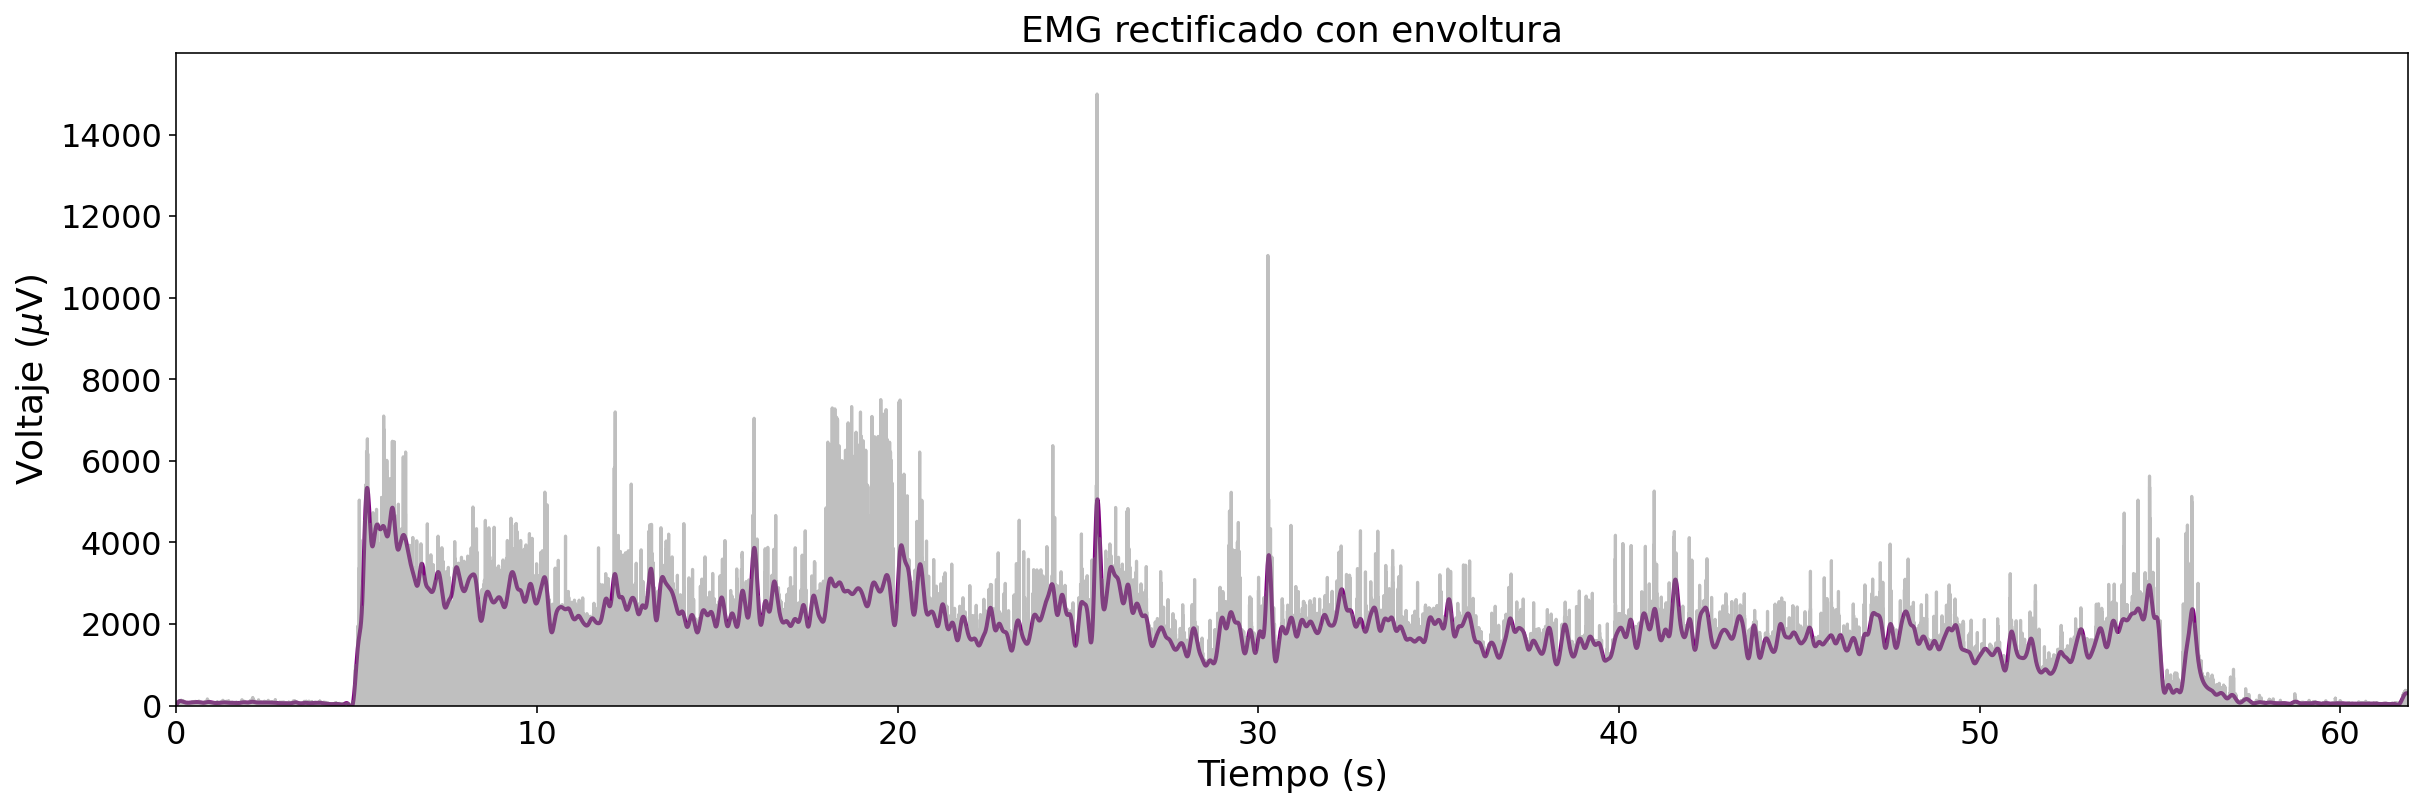

In [34]:
FrecMuestreo = wave.open('../Registros/S1/eccentric/S1_EMG_eccentric_trial0.wav').getframerate()
SeñalRelevante= EMG(archivo='../Registros/S1/eccentric/S1_EMG_eccentric_trial0.wav',graph=1)
fs = FrecMuestreo

<a id='Configuracióndeldetectordeeventos'></a>
## Configuración del detector de eventos 

In [76]:
threshold=7000  #Umbral
dt = .002       #Tiempo muerto de 2 ms
tm = .001       #Rango de búsqueda de 1 ms

crossings = detect_threshold_crossings(SeñalRelevante['AbsSeñal'], fs, threshold, dt) 
spks = align_to_minimum(SeñalRelevante['AbsSeñal'], fs, crossings, tm) 

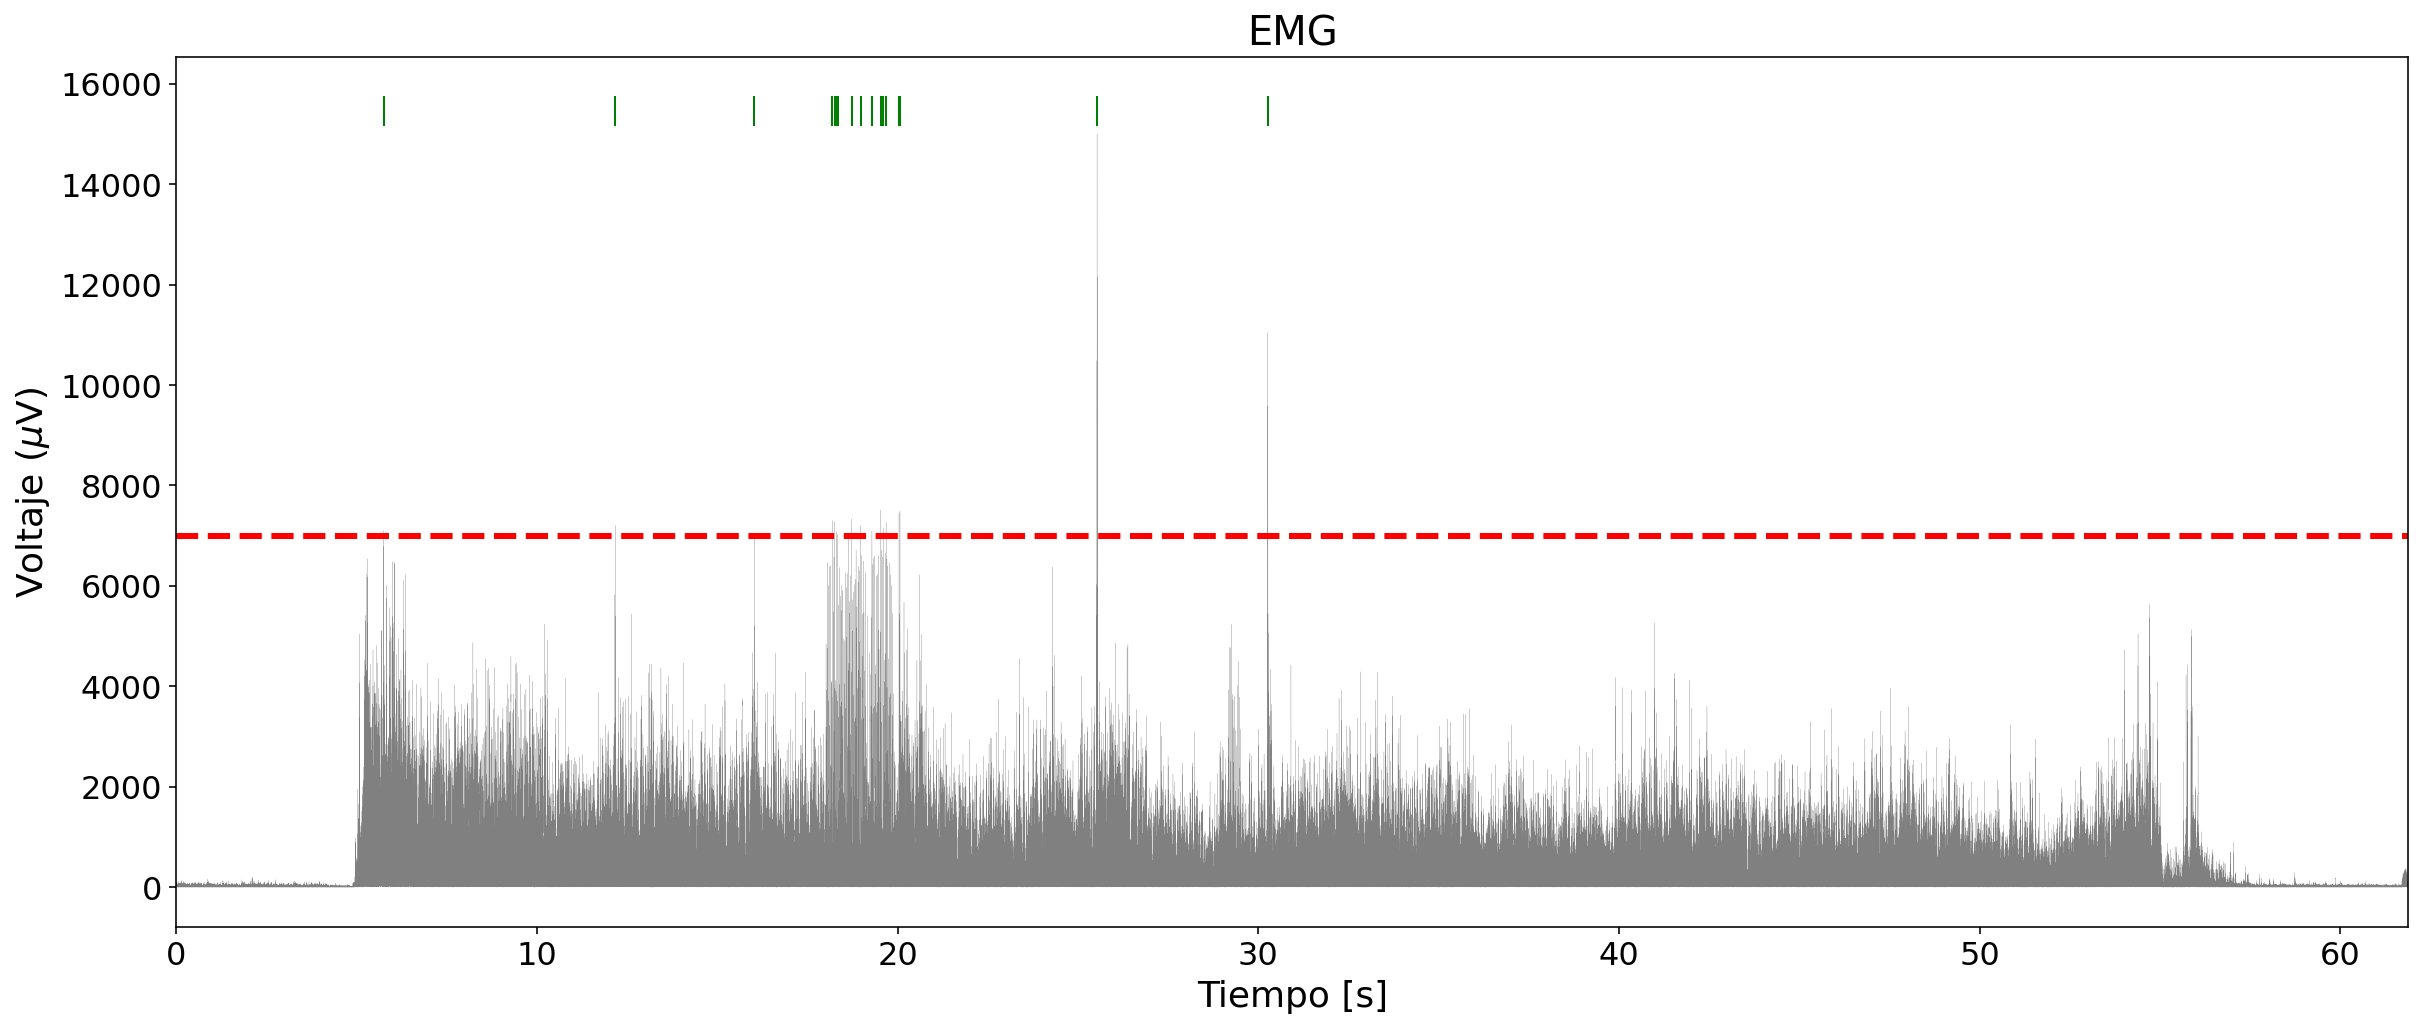

In [77]:
spike_time =spks/FrecMuestreo
cross_time =crossings/FrecMuestreo

#Graficamos EMG.
plt.figure(figsize=(20,8))
plt.title('EMG')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje ($\mu$V)')
plt.plot(SeñalRelevante['Abstiempo'],SeñalRelevante['AbsSeñal'],linewidth=.1,color='gray')
plt.xlim(0,max(SeñalRelevante['EMGtiempo']))
plt.axhline(y=threshold, color='red',linewidth=3.0, linestyle='--') 


for n in range(0, len(spike_time)):
    plt.vlines(x=spike_time[n], ymin=SeñalRelevante['AbsSeñal'].max() *1.01, 
                            ymax=SeñalRelevante['AbsSeñal'].max() *1.05,
                            color='green',linewidth=1.0, linestyle='-')
plt.show()

### Spike Waveforms:

Después de encontrar las marcas de tiempo de los picos, se podrá graficar y extraer las formas de onda de los picos (“Waveforms”), se cortamos una parte de la señal alrededor de cada pico, los picos demasiado cercanos al inicio o al final de la señal de que no es posible un corte completo se descarta.

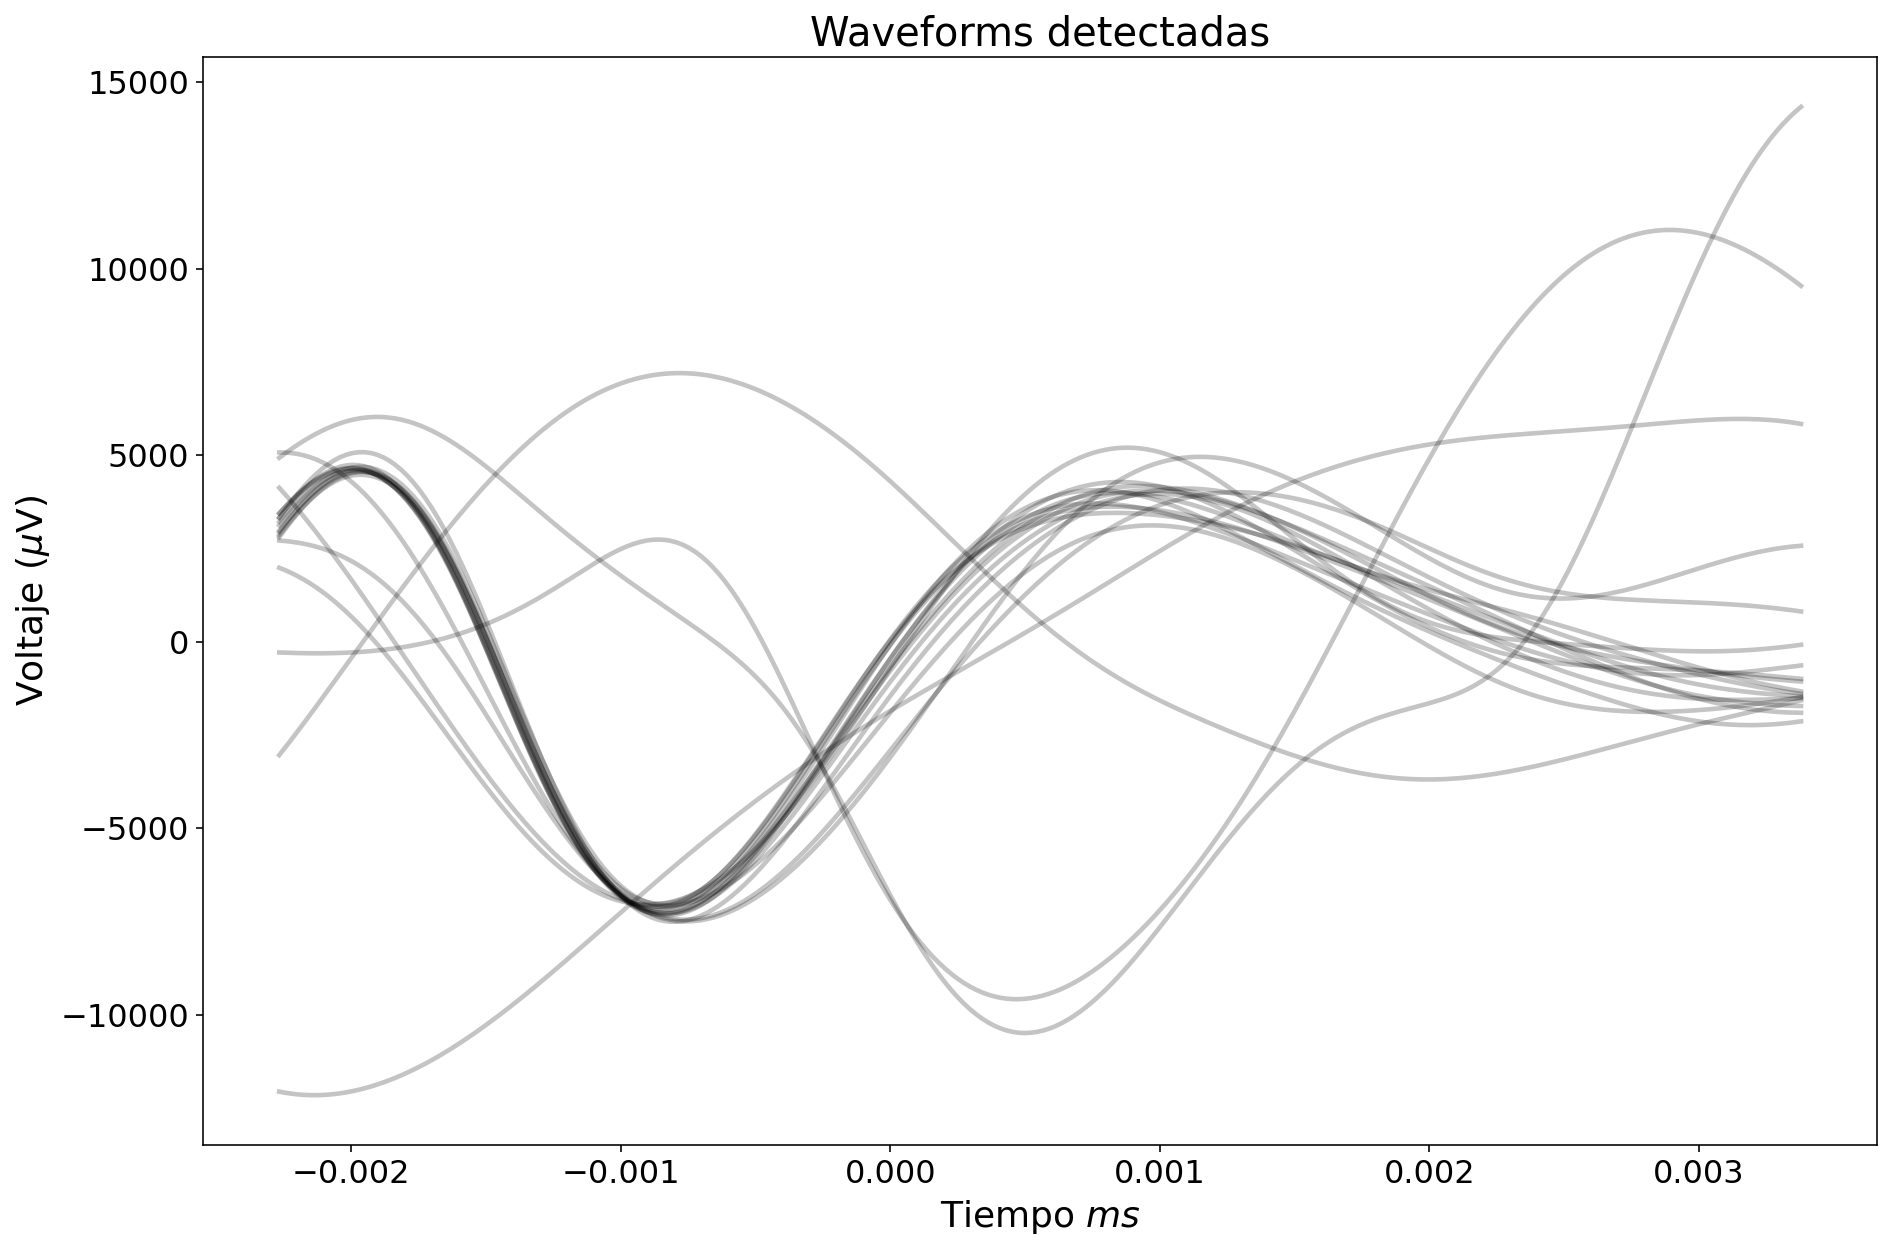

In [83]:
plt.figure(figsize=(15,10))
plt.title('Waveforms detectadas')
plt.xlabel('Tiempo ($ms$)')
plt.ylabel('Voltaje ($\mu$V)')

for spk_num in spks:
    plt.plot(np.arange(-100,150)/FrecMuestreo,
            SeñalRelevante['dataf'][spk_num-100:spk_num+150],
             alpha=.23,color='black',lw=2.3)
    
    plt.xticks()

<a id='Contandoelnúmerodedeteccionesdepicosporbin'></a>
## Contando el número de detecciones de picos por bin

Para contar el número de picos a medida que pasa el tiempo. Como resultado de la fatiga, deberíamos esperar una disminución en el número de pulsos con el tiempo.

In [90]:
bin_size = 5 #Longitud del bin(en segundos)

spikeBins = list(map(int,spike_time/bin_size)) #Bins que contienen picos
spikeBins = pd.DataFrame(spikeBins,columns=['Bin_Index'])

SpikeBin_count = pd.value_counts(spikeBins['Bin_Index']) #Cuenta el número de picos
                                                         #por bin
                                                         
SpikeBin_count = pd.DataFrame(SpikeBin_count)  #Transformar en un DataFrame
SpikeBin_count.columns = ['Recuento de picos']
SpikeBin_count

,Recuento de picos
3,11
4,2
5,2
1,1
2,1
6,1


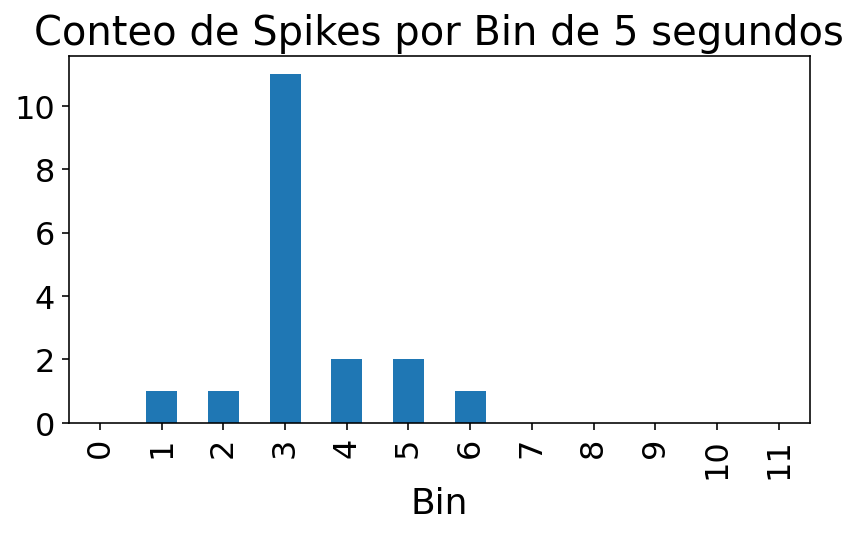

In [92]:
numBins = int(len(SeñalRelevante['Abstiempo'])/FrecMuestreo/bin_size) # Números de bins 

all_counts = np.zeros(numBins) #Inicializar matriz
all_counts[SpikeBin_count.index] = SpikeBin_count['Recuento de picos']
all_counts = pd.DataFrame(all_counts,columns=['Recuento de picos'])


# Trazando la gráfica:
from matplotlib.ticker import MaxNLocator  #Encuentra hasta un número máximo de intervalos con ticks en lugares adecuados.
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
all_counts['Recuento de picos'].plot(kind='bar')
plt.xlabel('Bin')
plt.title('Conteo de Spikes por Bin de {} segundos'.format(bin_size))
plt.tight_layout()

## Referencias
Registros y Notebook recuperado del repositorio elaborado por la Dra.Erin C. McKiernan, Noel Isaías Plascencia Díaz, Mitsui Myrna Salgado Saito, consultado en:
https://github.com/emckiernan/electrophys

Este trabajo fue apoyado por UNAM-DGAPA-PAPIME PE213817 y PE213219.